In [1]:
using Distributed
addprocs(5);

In [1]:
using LinearAlgebra
using SparseArrays
using Plots

In [2]:
using Revise
using LatticeQM

┌ Info: Precompiling LatticeQM [606d2a7e-9b17-11e9-1c5c-455b84f60309]
└ @ Base loading.jl:1317


In [3]:
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

## Calculation

In [4]:
lat = Geometries2D.honeycomb()
sx, sy, sz, sublA, sublB = getoperator(lat, ["SX", "SY", "SZ", "sublatticeAspin", "sublatticeBspin"])

hops = Operators.graphene(lat; mode=:spinhalf)
# Operators.addzeeman!(hops, lat, r->sign(r[4]-0.5).*0.5.*[sin(0.0π),0,cos(0.0π)] )

ks = kpath(lat; num_points=200)

nothing

Computing bands... 100%|████████████████████████████████| Time: 0:00:02


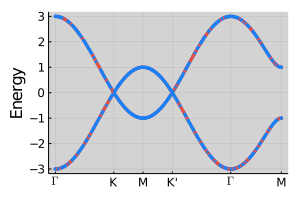

In [5]:
ks = kpath(lat; num_points=200)
bands = getbands(hops, ks, sz)
p1 = plot(bands; markersize=2, size=(300,200))

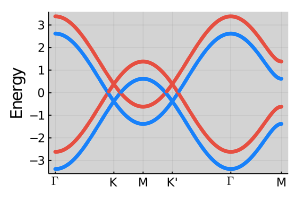

In [6]:
hopsBDG = BdGOperator(hops)
Operators.setfilling!(hopsBDG, 0.48)

eOP = Superconductivity.electron(hopsBDG)

ks = kpath(lat; num_points=200)
bands = getbands(hopsBDG.h, ks, eOP.h)
p1 = plot(bands; markersize=2, size=(300,200))

In [31]:
hopsBDG = BdGOperator(hops)
# v = gethubbard(lat; mode=:σx, a=0.5, U=-2.0) # interaction potential
v = Meanfield.getshortrangedpotential(lat, -2.4, 0.1)

ρ0_init = initialguess(v, :random; kind=:nonlocal) # initial guess
Δ0_init = initialguess(v, :random; kind=:nonlocal) # initial guess
ρ_init = BdGOperator(ρ0_init, Δ0_init)

ρ_sol, ϵ_GS, HMF, converged, error = Meanfield.solvehartreefock( # run the calculation
    hopsBDG, v, ρ_init, 0.48; klin=10, iterations=800, tol=1e-5,# p_norm=Inf,
    T=0.01, β=0.3,  show_trace=true, clear_trace=true
)
Operators.addchemicalpotential!(HMF.h, -HMF.μ)

nothing

FIXPOINT SEARCH  Time: 0:00:02 (300 iterations)
  iter:  300


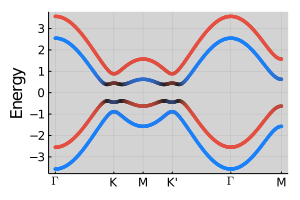

In [32]:
hmf = HMF.h
eOP = Superconductivity.electron(hmf)

bands_mf = getbands(hmf.h, ks, eOP.h)
# bands_mf.bands .-= HMF.μ # shift chemical potential to zero
p2 = plot(bands_mf; markersize=2, size=(300,200))

In [21]:
BANDGAP = Spectrum.bandgap(DenseHops(hmf.h); klin=30)

0.5138076349796823

In [82]:
M, SC = Operators.localobservables(ρ_sol, lat)
M = round.(real(M); digits=8)
SC = round.(SC; digits=8)

@info "Local density" M[1,:]
@info "Local magnetization" M[2,:] M[3,:] M[4,:]
@info "Local pair correlations (s-wave)" SC[1,:]
@info "Local pair correlations (non-swave)" SC[2,:] SC[3,:] SC[4,:]

┌ Info: Local density
│   M[1, :] = [1.20900547, 0.09094916]
└ @ Main In[82]:5
┌ Info: Local magnetization
│   M[2, :] = [-0.0, -0.0]
│   M[3, :] = [-0.0, -0.0]
│   M[4, :] = [-2.0e-8, 1.0e-8]
└ @ Main In[82]:6
┌ Info: Local pair correlations (s-wave)
│   SC[1, :] = ComplexF64[0.00555824 - 0.66508611im, 0.00059366 - 0.07103819im]
└ @ Main In[82]:7
┌ Info: Local pair correlations (non-swave)
│   SC[2, :] = ComplexF64[0.0 - 0.0im, -0.0 - 0.0im]
│   SC[3, :] = ComplexF64[0.0 - 0.0im, -0.0 + 0.0im]
│   SC[4, :] = ComplexF64[-0.56426541 - 0.00471567im, -0.06027171 - 0.00050382im]
└ @ Main In[82]:8


## Scanning parameters

In [71]:
# using SharedArrays

lat = Geometries2D.honeycomb()
ks = kpath(lat; num_points=200)

hops = Operators.graphene(lat; mode=:spinhalf)
hopsBDG = BdGOperator(hops)

Us = -LinRange(0,3.5,10)
Vs = LinRange(0,1.0,10)
filling = 0.48
klin = 10

BANDGAP = zeros(length(Us),length(Vs))
SWAVEAUP = zeros(length(Us),length(Vs))
SWAVEBUP = zeros(length(Us),length(Vs))
SWAVEADOWN = zeros(length(Us),length(Vs))
SWAVEBDOWN = zeros(length(Us),length(Vs))
WAVEdiff = zeros(length(Us),length(Vs))
DENSITY0 = zeros(length(Us),length(Vs))
DENSITYdiff = zeros(length(Us),length(Vs))
# BANDGAP = SharedArray(BANDGAP)
# SWAVE0 = SharedArray(SWAVE0)
# SWAVEdiff = SharedArray(SWAVEdiff)
# DENSITY0 = SharedArray(DENSITY0)
# DENSITYdiff = SharedArray(DENSITYdiff)

@showprogress for i_=1:length(Us), j_=1:length(Vs)
 
    U = Us[i_]; V = Vs[j_]
    v = Meanfield.getshortrangedpotential(lat, U, V)

    ρ0_init = initialguess(v, :random; kind=:nonlocal)
    Δ0_init = initialguess(v, :random; kind=:nonlocal)
    ρ_init = BdGOperator(ρ0_init, Δ0_init)

    ρ_sol, ϵ_GS, HMF, converged, error = Meanfield.solvehartreefock( # run the calculation
        hopsBDG, v, ρ_init, filling; klin=klin, iterations=1000, tol=1e-5,# p_norm=Inf,
        T=0.01, β=0.35,  show_trace=false, clear_trace=false
    )
    Operators.addchemicalpotential!(HMF.h, -HMF.μ)
    
    M, SC = Operators.localobservables(ρ_sol, lat)
    M = round.(real(M); digits=10)
    SC = round.(SC; digits=10)
    
    # save the data of interest
    BANDGAP[i_,j_] = Spectrum.bandgap(DenseHops(HMF.h.h); klin=30)
    SWAVEAUP[i_,j_] = abs(SC[1,1]+SC[4,1])
    SWAVEBUP[i_,j_] = abs(SC[1,2]+SC[4,2])
    SWAVEADOWN[i_,j_] = abs(SC[1,1]-SC[4,1])
    SWAVEBDOWN[i_,j_] = abs(SC[1,2]-SC[4,2])
    DENSITY0[i_,j_] = (M[1,1]+M[1,2])/2
    DENSITYdiff[i_,j_] = (M[1,1]-M[1,2])/2
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


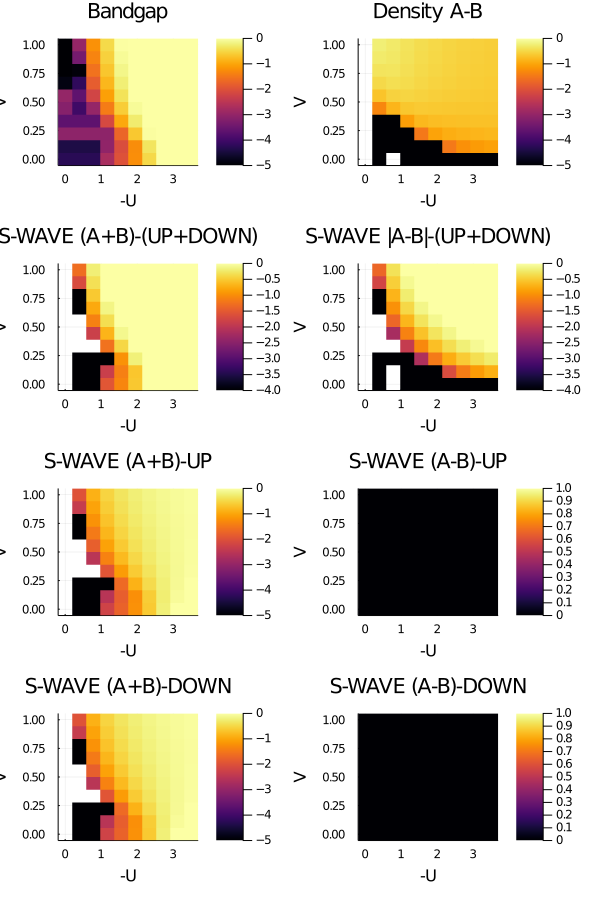

In [83]:
p1 = heatmap(-Us,Vs, log.(BANDGAP'); clims=(-5,0), xlabel="-U", ylabel="V", title="Bandgap", size=(300,300))
p2 = heatmap(-Us,Vs,log.(abs.(DENSITYdiff')); clims=(-5,0), xlabel="-U", ylabel="V", title="Density A-B", size=(300,300))
p3 = heatmap(-Us,Vs, log.(SWAVEAUP+SWAVEADOWN+SWAVEBUP+SWAVEBDOWN)'; clims=(-4,0), xlabel="-U", ylabel="V", title="S-WAVE (A+B)-(UP+DOWN)", size=(300,300))
p4 = heatmap(-Us,Vs, log.(abs.(SWAVEAUP+SWAVEADOWN-(SWAVEBUP+SWAVEBDOWN)))'; clims=(-4,0), xlabel="-U", ylabel="V", title="S-WAVE |A-B|-(UP+DOWN)", size=(300,300))

p5 = heatmap(-Us,Vs, log.(SWAVEAUP+SWAVEBUP)'; clims=(-5,0),  xlabel="-U", ylabel="V", title="S-WAVE (A+B)-UP", size=(300,300))
p6 = heatmap(-Us,Vs,(SWAVEBUP-SWAVEBUP)'; xlabel="-U", ylabel="V", title="S-WAVE (A-B)-UP", size=(300,300))
p7 = heatmap(-Us,Vs, log.(SWAVEADOWN+SWAVEBDOWN)'; clims=(-5,0), xlabel="-U", ylabel="V", title="S-WAVE (A+B)-DOWN", size=(300,300))
p8 = heatmap(-Us,Vs,(SWAVEBDOWN-SWAVEBDOWN)'; xlabel="-U", ylabel="V", title="S-WAVE (A-B)-DOWN", size=(300,300))

p = plot(p1,p2,p3,p4,p5,p6,p7,p8; layout=(4,2), size=(600,900))
display(p)

# p1 = heatmap(-Us,Vs,DENSITY0; xlabel="-U", ylabel="V", title="Density A+B", size=(300,300))
# p = plot(p1,p2; layout=(1,2), size=(500,200))
# display(p)

nothing